In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

<Figure size 1296x648 with 0 Axes>

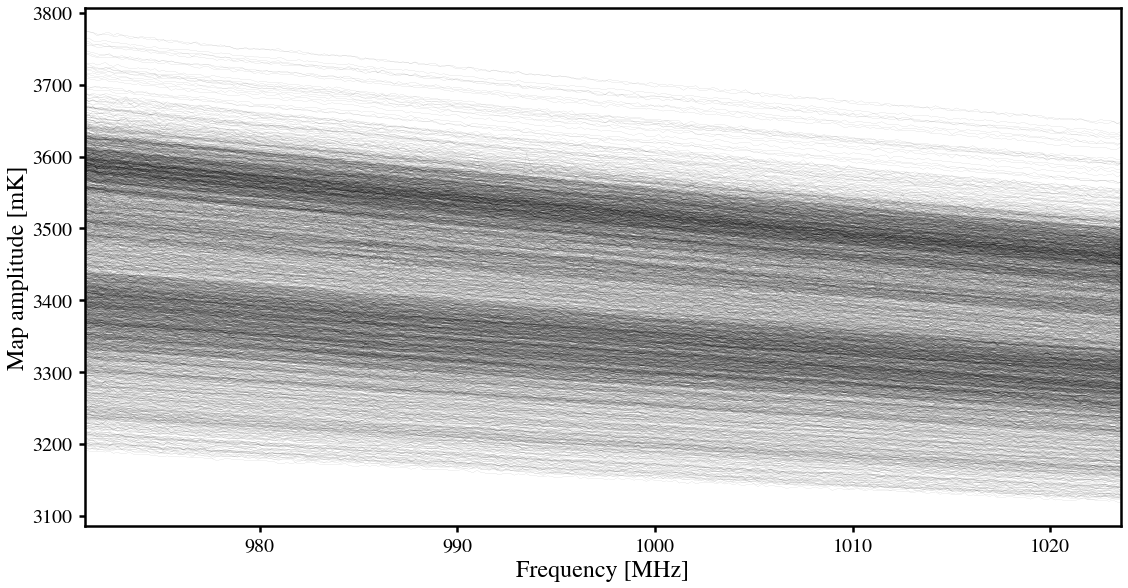

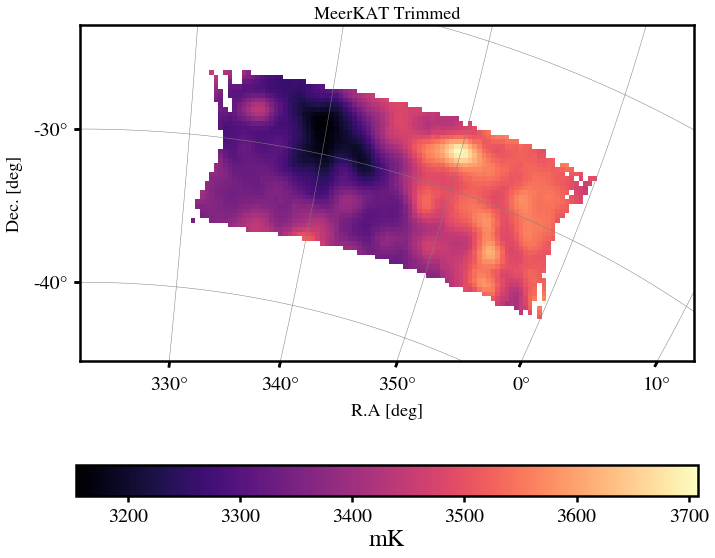

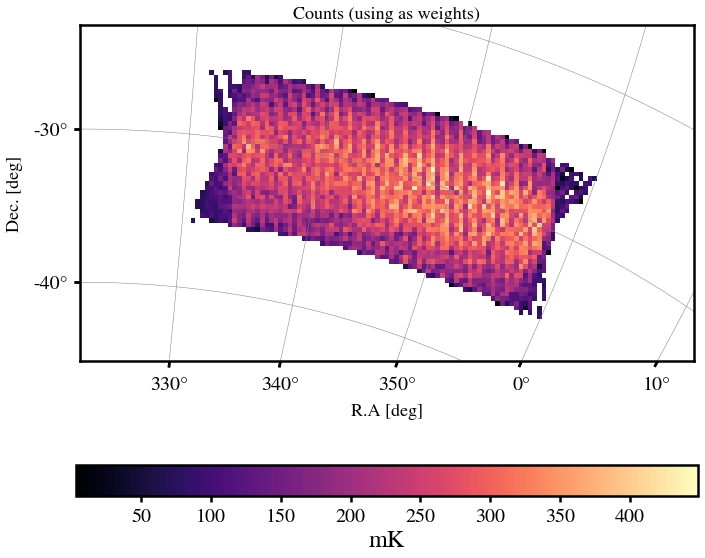

In [5]:
# Read-in level6 MeerKAT data:
#filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
#map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'

numin,numax = 971,1023.8 # default setting in Init.ReadIn()
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,numin=numin,numax=numax)
nx,ny,nz = np.shape(MKmap)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
gamma = 1.4
#gamma = None

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
'''
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
### Before trimming map, show contour of trimmed area:
MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)
contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
plt.show()
'''
plot.LoSspectra(MKmap,W=W_HI,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### IM weights (averaging of counts along LoS so not to increase rank of the map for FG cleaning):
w_HI = np.repeat(np.mean(counts_HI,2)[:, :, np.newaxis], nz, axis=2)

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Trimmed',cbarshrink=0.6)
plot.Map(counts_HI,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Counts (using as weights)',cbarshrink=0.6)
plt.show()

<Figure size 1296x648 with 0 Axes>

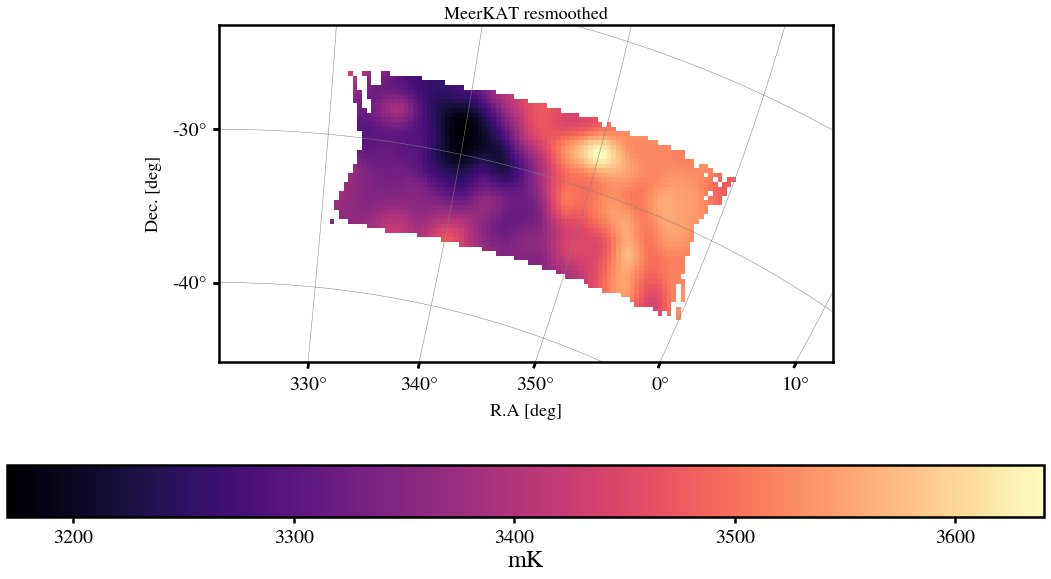

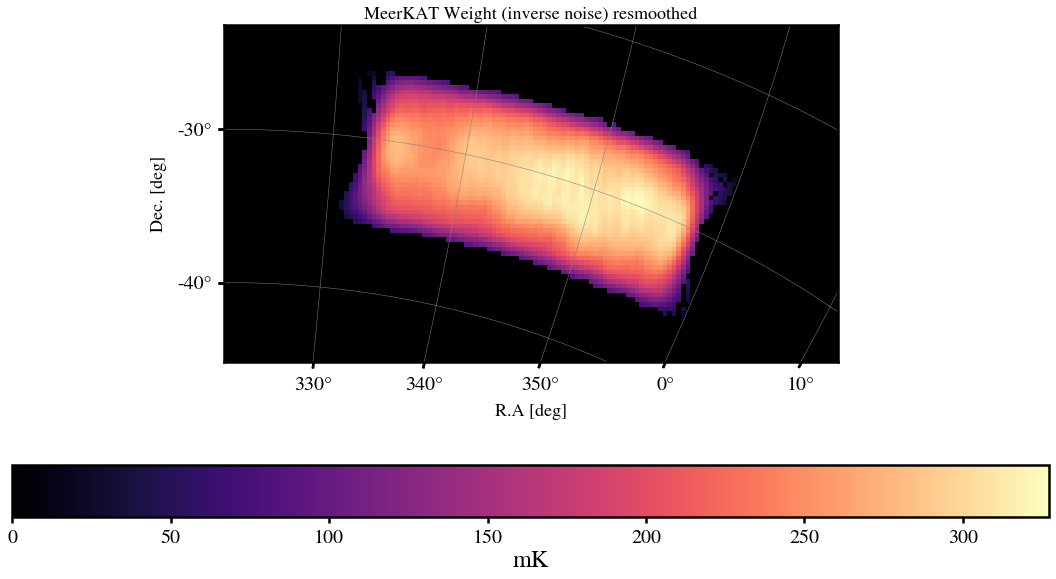

<Figure size 1296x648 with 0 Axes>

In [6]:
if gamma is not None:
    MKmap,w_HI = telescope.weighted_reconvolve(MKmap,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
    plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Weight (inverse noise) resmoothed')
plt.figure()
#exit()

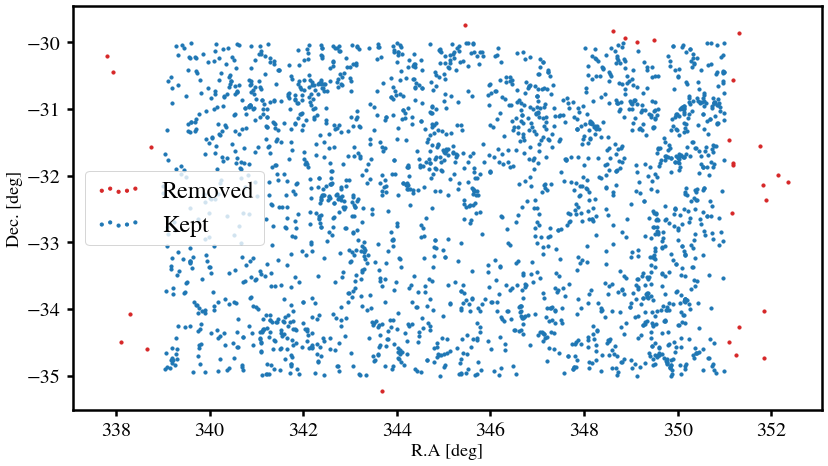

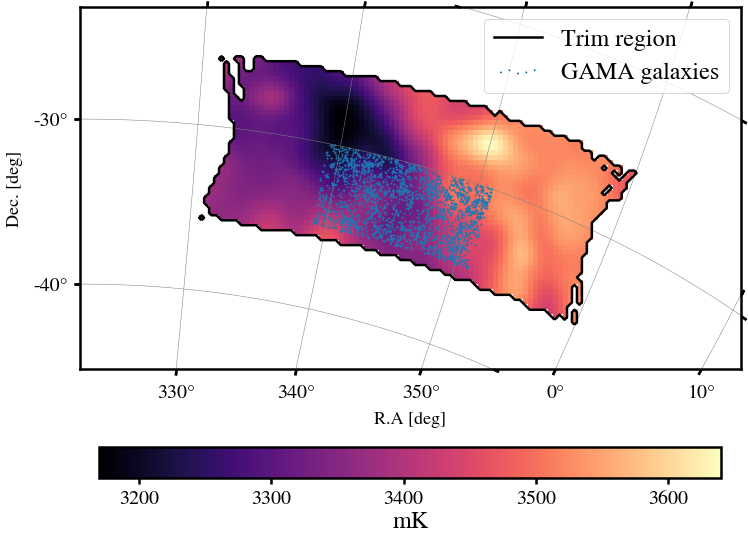

In [8]:
# Read-in GAMA galaxies:
from astropy.io import fits
Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
hdu = fits.open(Fits)
hdr = hdu[1].header
#print(hdr)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted

### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
plt.figure(figsize=(13,7))
plt.scatter(ra_g[~GAMAcutmask],dec_g[~GAMAcutmask],s=10,label='Removed',color='tab:red')
ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
plt.scatter(ra_g,dec_g,s=10,label='Kept',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### For null testing:
#np.random.shuffle(z_g)

### Plot MK map with overlaid GAMA galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap,2)
img[W_HI[:,:,0]==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label='GAMA galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.savefig('plots/GAMAxMKmap.png',bbox_inches='tight')
plt.show()

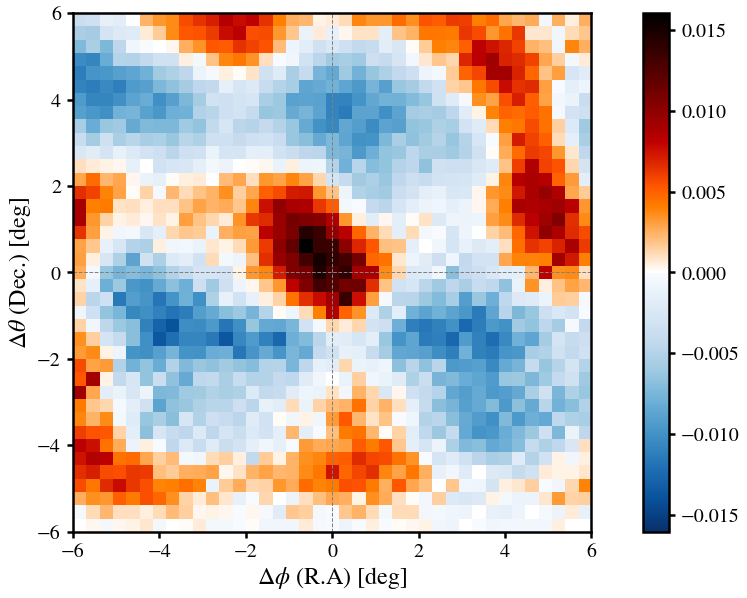

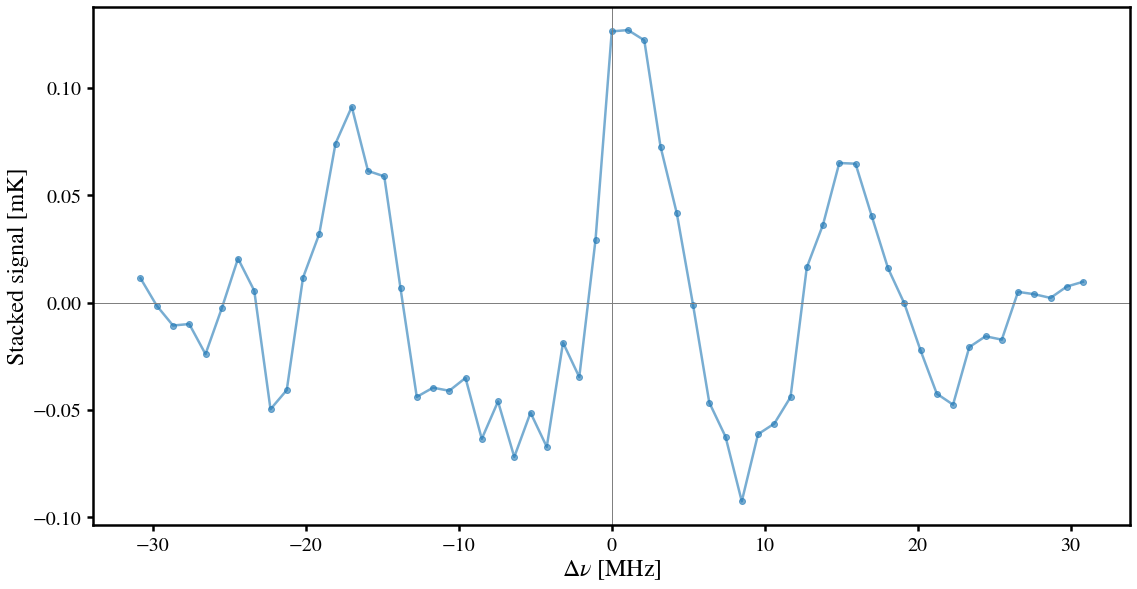

In [16]:
import foreground
N_fg = 10
MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI)

### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

ra_cont,ra_g_cont = np.copy(ra),np.copy(ra_g)
ra_cont[ra>180] = ra[ra>180] - 360
ra_g_cont[ra_g>180] = ra_g[ra_g>180] - 360

import stack
degmax = 6 # max/min of stacked map [deg]
ddegpix = 0.3 # width of stacked pixels [deg]
ddeg,counts = stack.angular(MKmap_clean,W_HI,ra_g_cont,dec_g,z_g,ra_cont,dec,nu,degmax,ddegpix,dnu=5,w=None)
np.save('/idia/projects/hi_im/meerpower/2021Lband/gama/data/stackang_result_Nfg=%s'%N_fg,[ddeg,counts])

plt.imshow(ddeg,extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(ddeg),vmax=np.max(ddeg),cmap=mycmap)
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
#plt.title(r'$N_{\rm fg}=$%s'%N_fg)
plt.show()

nnu_stack = 150 # +/- nnu_stack channels either side of centred galaxy redshift
nnu_bins = 60 # number of bins
d,nustack_bins = stack.spectral(MKmap_clean,W_HI,ra_g,dec_g,z_g,ra,dec,nu,nnu_stack,nnu_bins)
plt.plot(nustack_bins,d,'-o',alpha=0.6)
plt.axhline(0,lw=1,color='gray')
plt.axvline(0,lw=1,color='gray')
plt.xlabel(r'$\Delta\nu$ [MHz]')
plt.ylabel('Stacked signal [mK]')
plt.show()
